# Deep Learning with PyTorch : Build a Generative Adversarial Network 

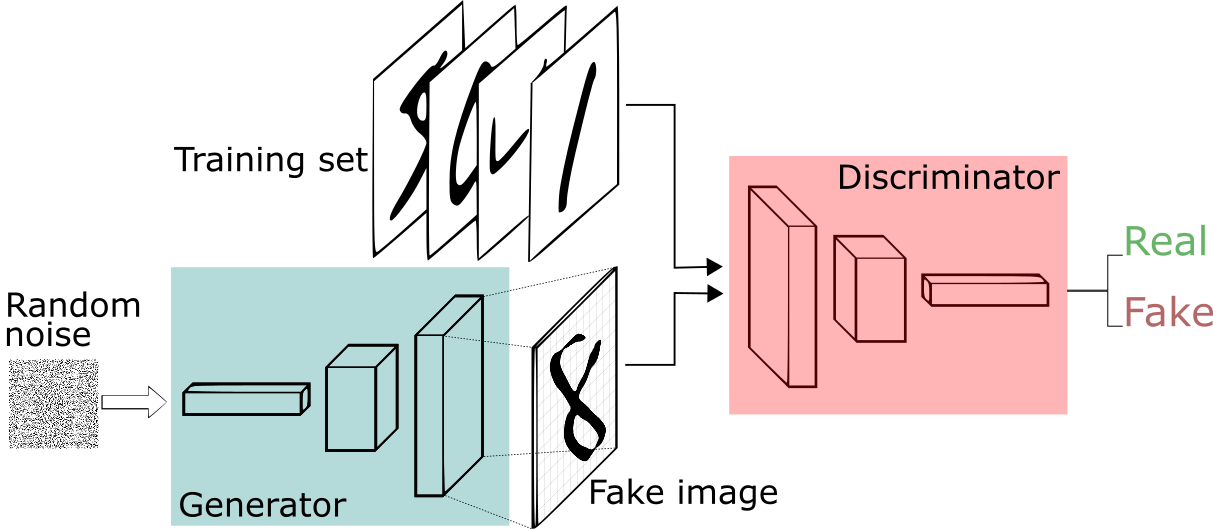

In [ ]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm
# Import the Images module from pillow
from PIL import Image
import numpy as np
import skimage
import os
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configurations

In [ ]:
# device = 'cuda' # used to transer images to device --> image = image.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 10

# opt parmas
lr = 0.005 #danny
beta_1 = 0.5
beta_2 = 0.99

#train vars
epochs = 100

size = 256,256
img_dir = '/content/drive/MyDrive/data/'
im1 = Image.open('/content/drive/MyDrive/data/00000001_000.png')


In [ ]:
def reduce_size(image):
  im_resized = image.resize(size, Image.LANCZOS)
  return np.array(im_resized).reshape(1,*size)/255

In [ ]:
im1 = Image.open('/content/drive/MyDrive/data/00000001_000.png')
im1 = reduce_size(im1)
im1.min(   )
im1 = im1 + 0.05 * np.random.randn(*im1.shape)

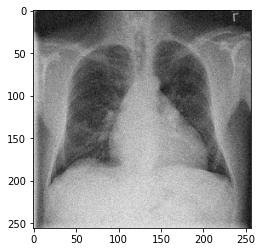

In [ ]:
plt.imshow(im1[0],cmap='gray')

In [ ]:
def create_training_data(img_dir):
  real_images = []
  noisy_images = []
  for f in tqdm(os.listdir(img_dir)):
    if os.path.splitext(f)[1] not in ['.png', '.jpg', '.jpeg']:
      continue
    image = Image.open(img_dir + str(f))
    image = reduce_size(image)
    if len(image.shape)>3:
      continue
    real_images.append(image)
    noisy_image = image + 0.05 * np.random.randn(*image.shape)
    noisy_images.append(noisy_image)
  return torch.tensor(real_images).double(), torch.tensor(noisy_images).double()


In [ ]:
real_images, noisy_images = create_training_data(img_dir)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
noisy_images.dtype

torch.float64

In [ ]:
a = torch.stack((real_images,noisy_images), axis=1)
a.shape

torch.Size([200, 2, 1, 256, 256])

# Load Dataset Into Batches 

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms 
from torchvision.transforms import InterpolationMode

In [ ]:
real_image_loader = DataLoader(real_images, batch_size=batch_size, shuffle = True)

In [ ]:
a_loader = DataLoader(a, batch_size=batch_size, shuffle = True)

In [ ]:
len(a_loader)


20

In [ ]:
noisy_image_loader = DataLoader(noisy_images, batch_size=batch_size, shuffle = True)

In [ ]:
len(real_image_loader)

20

In [ ]:
for image in tqdm(a_loader):
  print(image[0].shape)
  # real_image = image[0]
  # noisy_image = image[1]

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])


In [ ]:
dataiter = iter(a_loader)

batch = dataiter.next()

batch0 = batch[:,0]
batch1 = batch[:,1]

In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 9, size=(1, 128, 128)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=3)
    plt.figure(figsize=(10,10))
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

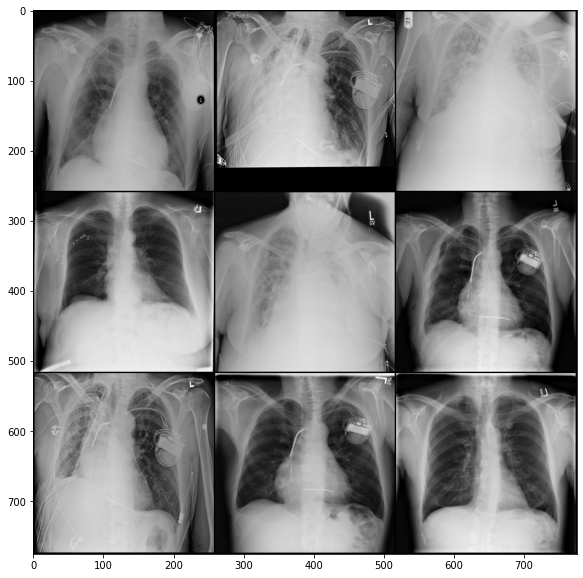

In [ ]:
show_tensor_images(batch0)

# Create Discriminator Network 

In [ ]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 128, 128)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 63, 63)
BatchNorm2d()                                                                                          #(bs, 16, 63, 63)
LeakyReLU()                                                                                            #(bs, 16, 63, 63)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 30, 30)
BatchNorm2d()                                                                                          #(bs, 32, 30, 30)
LeakyReLU()                                                                                            #(bs, 32, 30, 30)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
LeakyReLU()                                                                                            #(bs, 64, 13, 13)
      |
      V
Conv2d( in_channels = 64, out_channels = 128, kernel_size = (5,5), stride = 2)                         #(bs, 128, 5, 5)
BatchNorm2d()                                                                                          #(bs, 128, 5, 5)
LeakyReLU()                                                                                            #(bs, 128, 5, 5)
      |
      V     
Conv2d( in_channels = 128, out_channels = 256, kernel_size = (5,5), stride = 2)                        #(bs, 256, 1, 1)
BatchNorm2d()                                                                                          #(bs, 256, 1, 1)
LeakyReLU()                                                                                            #(bs, 256, 1, 1)
      |
      V       
Flatten()                                                                                              #(bs, 256)
Linear(in_features = 256, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 128, 128)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 63, 63)\nBatchNorm2d()                                                                                          #(bs, 16, 63, 63)\nLeakyReLU()                                                                                            #(bs, 16, 63, 63)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 30, 30)\nBatchNorm2d()                                                                                          #(bs, 32, 30, 30)\nLeakyReLU()                                                                                            #(bs, 32, 30, 30)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64

In [ ]:
from torch.nn.modules.activation import LeakyReLU
def get_disc_block(in_channels, out_channels, kernel_size, stride, padding=0):
  model = nn.Sequential(
      nn.Conv2d( in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding=padding),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU()
  )
  return model

  



In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block1 = get_disc_block(1,48,(4,4),2)
    self.block2 = get_disc_block(48,96,(4,4),2)
    self.block3 = get_disc_block(96,192,(4,4),2)
    self.block4 = get_disc_block(192,384,(4,4),1,'same')

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=384, out_features=1)

  def forward(self, images):
    output = self.block1(images)
    output = self.block2(output)
    output = self.block3(output)
    output = self.block4(output)
    output = self.linear(self.flatten(output))
    return output





In [ ]:
D = Discriminator()
D.double()
D.to(device)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block4): Sequential(
    (0): Conv2d(192, 384, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=384, out_features=1, bias=

In [ ]:
# summary(D, input_size=(1,*size),)

# Create Generator Network 

In [ ]:
'''

Network : Generator 

input : (bs,1,128,128)

      |
      | 
      V
Conv2d( in_channels = 1, out_channels = 32, kernel_size = (3,3), stride = 2)                      #(bs, 32, 63, 63)
BatchNorm2d()                                                                                     #(bs, 32, 63, 63)
LeakyReLU()                                                                                       #(bs, 32, 63, 63)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (3,3), stride = 3)                     #(bs, 64, 21, 21)
BatchNorm2d()                                                                                     #(bs, 64, 21, 21)
LeakyReLU()                                                                                       #(bs, 64, 21, 21)
      |
      V
Conv2d( in_channels = 64, out_channels = 128, kernel_size = (5,5), stride = 2)                    #(bs, 128, 9, 9)
BatchNorm2d()                                                                                     #(bs, 128, 9, 9)
LeakyReLU()                                                                                       #(bs, 128, 9, 9)
      |
      V      
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)           #(bs, 64, 19, 19)
BatchNorm2d()                                                                                     #(bs, 64, 19, 19)
ReLU()                                                                                            #(bs, 64, 19, 19)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 32, kernel_size = (6,6), stride = 2)            #(bs, 64, 42, 42)
BatchNorm2d()                                                                                     #(bs, 64, 42, 42)
ReLU()                                                                                            #(bs, 64, 42, 42)
      |
      V      
ConvTranspose2d( in_channels = 32, out_channels = 1, kernel_size = (5,5), stride = 3)             #(bs, 1, 128, 128)
Tanh()                                                                                            #(bs, 1, 128, 128)

'''

In [ ]:
def get_gen_blockConv(in_channels, out_channels, kernel_size, stride):
  model = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU()
  )
  return model

def get_gen_blockConvT(in_channels, out_channels, kernel_size, stride):
  model = nn.Sequential(
      nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )
  return model

def get_gen_blockResidual():
  return 0

# def get_gen_blockResizeDeconv(img_size, out_channels):
#   T = transforms.Resize((img_size, img_size), InterpolationMode.NEAREST)
#   return get_gen_blockConv(in_channels, out_channels, kernel_size, stride)

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    
    # self.noise_dim = noise_dim
    self.block1 = get_gen_blockConv(1, 32, (9,9), 1)
    self.block2 = get_gen_blockConv(32, 64, (3,3), 1)
    self.block3 = get_gen_blockConv(64, 128, (3,3), 1)

    self.blockResConv = get_gen_blockConv(128, 128, (3,3), 1)

    self.block4 = get_gen_blockConv(128, 64, (3,3), 1)
    self.block5 = get_gen_blockConv(64, 32, (3,3), 1)

    self.lastconv = get_gen_blockConv(32, 1, (9,9), 1)
    self.tanh = nn.Tanh()

  def resnet_forward(self, input):
    output = self.blockResConv(input)
    output = self.blockResConv(input)
    output = output + input
    return output

  def forward(self,noisy_image):
    # r_noise_vec = r_noise_vec.view(-1,self.noise_dim,1,1) # danny
    conv1 = self.block1(noisy_image)
    conv2 = self.block2(conv1)
    conv3 = self.block3(conv2)
    res1 = self.resnet_forward(conv3)
    res2 = self.resnet_forward(res1)
    res3 = self.resnet_forward(res2)
    
    T1 = transforms.Resize((128, 128), InterpolationMode.NEAREST)
    deconv1 = self.block4(T1(res3))

    T2 = transforms.Resize((256, 256), InterpolationMode.NEAREST)
    deconv2 = self.block5(T2(deconv1))
    deconv2 = deconv2 + conv1

    conv4 = self.lastconv(deconv2)
    conv4 = self.tanh(conv4)
    conv4 = conv4 + noisy_image

    output = (conv4+1)/2
    return output



In [ ]:
G = Generator()
G.to(device)
G.double()

Generator(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (blockResConv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e

In [ ]:
# summary(G, input_size=(1,*size) )

In [ ]:
noise = torch.randn(1,64)
noise.reshape(1,64,1,1).shape

torch.Size([1, 64, 1, 1])

In [ ]:
noise.view(-1,64,1,1).shape

torch.Size([1, 64, 1, 1])

In [ ]:

# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  y_true = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, y_true)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  y_true = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, y_true)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output.backward()

In [ ]:
output

tensor(1.6269, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Training Loop 

In [ ]:
for it in range(epochs):
  print('Epoch Number:', it+1)
  total_d_loss = 0.0
  total_g_loss = 0.0
  for images in tqdm(a_loader):
    
    real_image = images[:,0]
    real_image = real_image.to(device)
    noisy_image = images[:,1]
    noisy_image = noisy_image.to(device)

    #D loss
    D_opt.zero_grad()

    fake_image = G(noisy_image) #danny
    D_fake_image = D(fake_image)
    fake_image_loss = fake_loss(D_fake_image)

    D_real_image = D(real_image) #danny
    real_image_loss = real_loss(D_real_image)

    D_loss = (real_image_loss + fake_image_loss)/2 #danny
    total_d_loss += D_loss.item()

    D_loss.backward() 
    # this calculate backwards for alllllll involved params. 
    # but the D_opt decides which to update.
    # so the graph for all params including G have been traversed
    # therefore need to create a new graph with all the params from scratch

    D_opt.step()

    #G loss
    G_opt.zero_grad()

    fake_image = G(noisy_image) #danny
    D_fake_image = D(fake_image)
    G_loss = real_loss(D_fake_image)
    
    # G_loss = - fake_loss(D_fake_image) #danny
    
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(a_loader)
  avg_g_loss = total_g_loss/len(a_loader)
  print('avg_d_loss', avg_d_loss)
  print('avg_g_loss', avg_g_loss)

  show_tensor_images(fake_image)


Epoch Number: 1


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.1478809935014957
avg_g_loss 3.6342683252749413


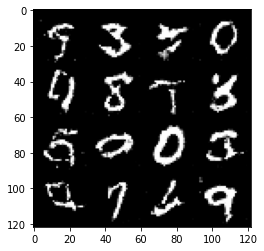

Epoch Number: 2


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.18288472317047974
avg_g_loss 3.410818828448558


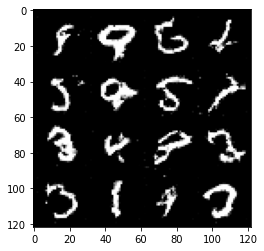

Epoch Number: 3


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.18779627499041526
avg_g_loss 3.3797717737490687


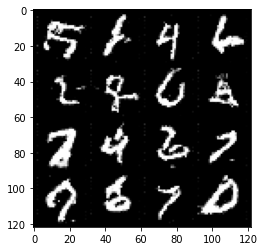

Epoch Number: 4


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20416652725767226
avg_g_loss 3.3809886583641395


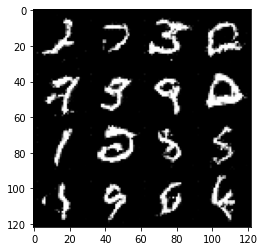

Epoch Number: 5


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.2053844068509175
avg_g_loss 3.320005664184912


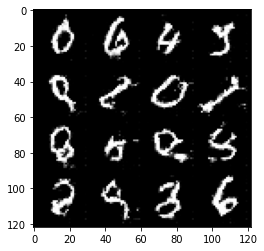

Epoch Number: 6


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.19308313380267575
avg_g_loss 3.389832255174356


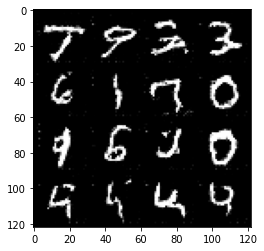

Epoch Number: 7


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.21028843252802454
avg_g_loss 3.3402421149109474


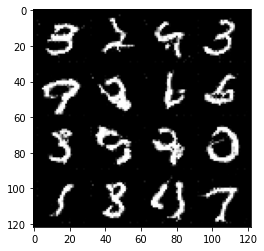

Epoch Number: 8


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20551884874923906
avg_g_loss 3.3393433228738783


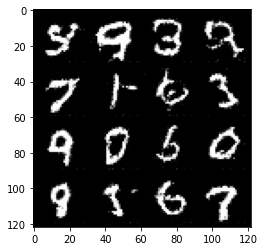

Epoch Number: 9


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.19414933446818577
avg_g_loss 3.3995082028893266


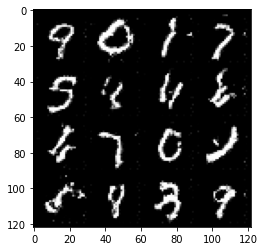

Epoch Number: 10


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.19200036266465176
avg_g_loss 3.455786462785847


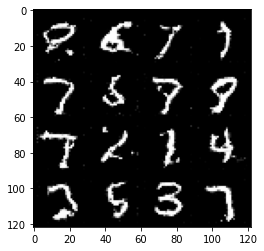

Epoch Number: 11


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.19693622213881662
avg_g_loss 3.408856274222514


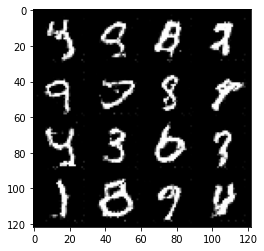

Epoch Number: 12


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20255826921192313
avg_g_loss 3.4564626007191914


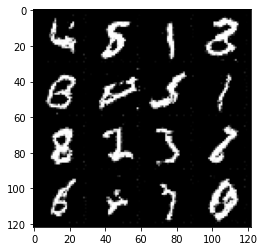

Epoch Number: 13


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20800889354906102
avg_g_loss 3.398551389606777


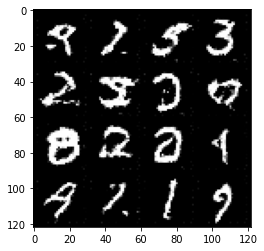

Epoch Number: 14


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.19809998547249258
avg_g_loss 3.4926904811025428


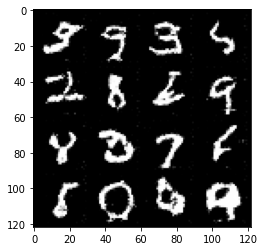

Epoch Number: 15


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20970497073839978
avg_g_loss 3.4638746834512966


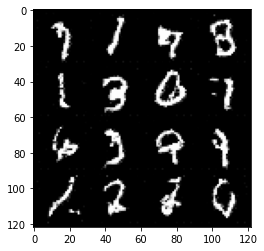

Epoch Number: 16


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20771357023131365
avg_g_loss 3.5005650062805045


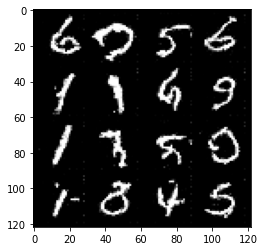

Epoch Number: 17


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.2070730018463216
avg_g_loss 3.4232443766807443


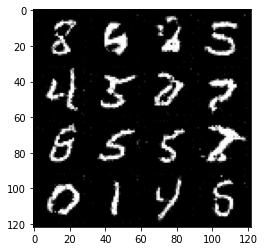

Epoch Number: 18


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.20749694503732583
avg_g_loss 3.470837621546503


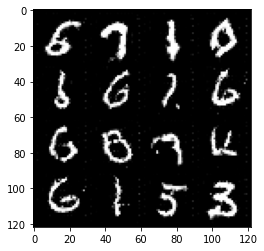

Epoch Number: 19


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.1966846074456218
avg_g_loss 3.5565135288340195


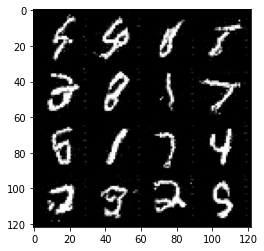

Epoch Number: 20


  0%|          | 0/469 [00:00<?, ?it/s]

avg_d_loss 0.1942564569858473
avg_g_loss 3.531895556937911


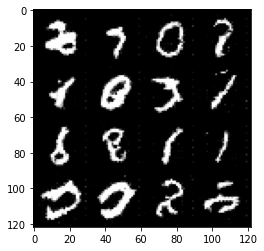

In [ ]:
for it in range(epochs):
  print('Epoch Number:', it+1)
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_image, _ in tqdm(trainloader):
    
    real_image = real_image.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    #D loss
    D_opt.zero_grad()

    fake_image = G(noise) #danny
    D_fake_image = D(fake_image)
    fake_image_loss = fake_loss(D_fake_image)

    D_real_image = D(real_image) #danny
    real_image_loss = real_loss(D_real_image)

    D_loss = (real_image_loss + fake_image_loss)/2 #danny
    total_d_loss += D_loss.item()

    D_loss.backward() 
    # this calculate backwards for alllllll involved params. 
    # but the D_opt decides which to update.
    # so the graph for all params including G have been traversed
    # therefore need to create a new graph with all the params from scratch

    D_opt.step()

    #G loss
    G_opt.zero_grad()

    fake_image = G(noise) #danny
    D_fake_image = D(fake_image)
    G_loss = real_loss(D_fake_image)
    
    # G_loss = fake_image_loss #danny
    
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)
  print('avg_d_loss', avg_d_loss)
  print('avg_g_loss', avg_g_loss)

  show_tensor_images(fake_image)


In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya